In [1]:
import geopandas as gpd
import pandas as pd
import copy
import os
import warnings
import random
from pprint import pprint
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from srai.datasets import AirbnbMulticityDataset
from srai.embedders import Hex2VecEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders.osm_loaders import OSMPbfLoader
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from srai.neighbourhoods.h3_neighbourhood import H3Neighbourhood
from srai.plotting import plot_regions
from srai.regionalizers import H3Regionalizer
import plotly.graph_objs as go
from shapely.geometry import LineString, Point
from shapely import from_geojson
import h3
from srai.h3 import h3_to_geoseries
import matplotlib.pyplot as plt
import pickle

In [2]:
tqdm.pandas()

In [3]:
H3_RESOLUTION = 10
seq_length = 15

In [4]:
embeddings = pd.read_parquet(os.path.join('output_data', f'embeddings_{H3_RESOLUTION}.parquet'))
embeddings.shape

(1539480, 10)

In [5]:
gdf = gpd.read_parquet(os.path.join('output_data', 'geolife_pekin_clean_small.parquet'))

In [6]:
gdf = gdf.to_crs(4326)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
gdf.shape

(13332, 5)

In [8]:
gdf.head()

,geometry,time,altitude,trajectory_id,contains_outlier
0,"LINESTRING (116.32702 39.98899, 116.32704 39.9...","[2000-01-01T23:12:19.000000, 2000-01-01T23:13:...","[128.937004593176, 221.128615485564, 217.19159...",20000101231219,False
1,"LINESTRING (116.33038 39.97423, 116.33045 39.9...","[2007-04-12T09:31:32.000000, 2007-04-12T09:39:...","[823.490813648294, 823.490813648294, 741.46981...",20070412093132,False
2,"LINESTRING (116.33028 39.97552, 116.33040 39.9...","[2007-04-12T10:18:53.000000, 2007-04-12T10:20:...","[351.049868766404, 114.829396325459, 114.82939...",20070412101853,False
3,"LINESTRING (116.33007 39.97647, 116.33015 39.9...","[2007-04-12T10:21:16.000000, 2007-04-12T10:21:...","[173.884514435696, 173.884514435696, 173.88451...",20070412102116,False
4,"LINESTRING (116.33040 39.97585, 116.33047 39.9...","[2007-04-12T10:23:25.000000, 2007-04-12T10:24:...","[114.829396325459, 114.829396325459, 118.11023...",20070412102325,False


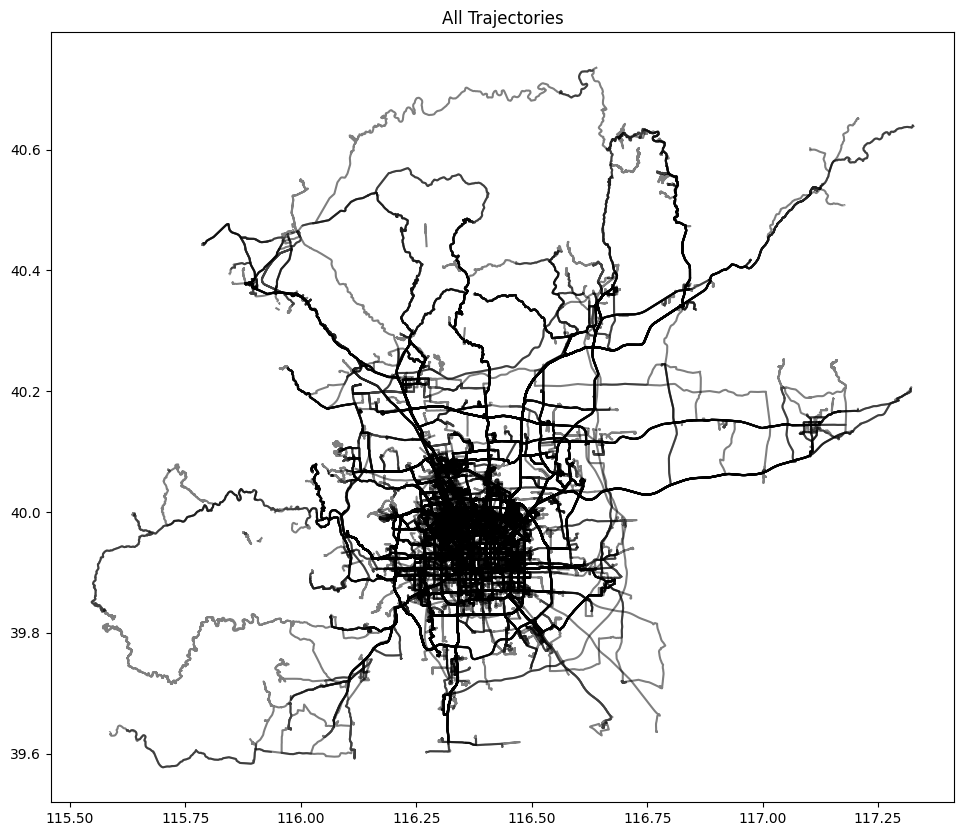

In [9]:
gdf.plot(figsize=(20, 10), alpha=0.5, edgecolor='k')
plt.title('All Trajectories')
plt.show()

In [10]:
def get_hex_neigh(traj):
    h3_dist = []
    h3_cells = []
    points = traj.coords
    try:
        for idx in range(len(points) - 1):
            a, b = points[idx], points[idx + 1]
            start_hex = h3.latlng_to_cell(a[1], a[0], H3_RESOLUTION)
            end_hex = h3.latlng_to_cell(b[1], b[0], H3_RESOLUTION)
            if start_hex == end_hex:
                continue
            for h3_cell in h3.grid_path_cells(start_hex, end_hex):
                if not h3_cells or h3_dist[-1] != h3_cell:
                    h3_dist.append(h3_cell)
                    h3_cells.append(h3.grid_disk(h3_cell, 1))
        return h3_cells
    except:
        return []

In [11]:
dummies = pd.get_dummies([1, 2, 3, 4, 5, 6])

In [12]:
def get_y(traj):
    if not traj:
        return None
    y = []
    for i in range(len(traj) - 1):
        target = traj[i + 1][0]
        prop = np.array(traj[i])
        res = prop == target
        idx = np.where(res)[0]-1
        try:
            dummy = dummies.loc[idx].values[0]
        except:
            print(idx)
        y.append(dummy)
    return y

In [13]:
# t = gdf_agg['geometry'].iloc[5]
# cells = get_hex_neigh(t)
# pprint(len(cells))
# y = get_y(cells)
# print(len(y))
# em = embed(cells)
# pprint(em[0])

In [14]:
def embed(traj):
    emb = []
    for t in traj:
        temp = []
        for h in t:
            try:
                temp.append(embeddings.loc[h].values)
            except:
                return None
        emb.append(temp)
    return emb

In [15]:
gdf['hex_neigh'] = gdf['geometry'].progress_apply(get_hex_neigh)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13332/13332 [00:46<00:00, 284.01it/s]


In [16]:
gdf['y'] = gdf['hex_neigh'].progress_apply(get_y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13332/13332 [02:28<00:00, 90.02it/s]


In [17]:
gdf['neigh_emb'] = gdf['hex_neigh'].progress_apply(embed)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13332/13332 [02:12<00:00, 100.27it/s]


In [18]:
gdf = gdf[gdf['neigh_emb'].notnull()]
gdf = gdf[gdf['y'].notnull()]

In [19]:
gdf.shape

(13120, 8)

In [20]:
gdf = gdf[gdf['neigh_emb'].apply(lambda x: len(x) >= seq_length)]

In [21]:
gdf.shape

(11516, 8)

# Train test split

In [22]:
train, test = train_test_split(gdf, test_size=0.2, random_state=42)

In [23]:
train.shape # 6246, [clean]:hex10-12k, , hex8-7k, hex9- 9k

(9212, 8)

# SEQUENCE GENERATION

In [24]:
def make_pad_seq(row, seq_len=seq_length, batch_size=256):
    empty = list(np.zeros_like(np.array(row['neigh_emb'][0]).flatten().tolist()))
    batch = []
    
    for i in range(len(row['y']) - 1):
        seq = [empty for _ in range(seq_len)]
        
        start = max(0, i - seq_len + 1)
        end = i + 1
        
        for j in range(start, end):
            seq[seq_len - (i - j + 1)] = np.array(row['neigh_emb'][j]).flatten().tolist()
        
        batch.append((seq, row['y'][i]))
        
        # When batch size is reached, yield the batch
        if len(batch) == batch_size:
            yield batch
            batch = []
    
    # Yield any remaining items in the batch
    if batch:
        yield batch

In [25]:
batch_size = 32
all_batches = []

for _, row in tqdm(train.iterrows(), total=len(train), desc="Processing Rows"):
    for batch in make_pad_seq(row, seq_len=seq_length, batch_size=batch_size):
        all_batches.extend(batch)

train_seq = pd.DataFrame(all_batches, columns=['seq', 'y'])

Processing Rows: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9212/9212 [20:58<00:00,  7.32it/s]


In [26]:
batch_size = 64
all_batches = []

for _, row in tqdm(test.iterrows(), total=len(test), desc="Processing Rows"):
    for batch in make_pad_seq(row, seq_len=seq_length, batch_size=batch_size):
        all_batches.extend(batch)
            
test_seq = pd.DataFrame(all_batches, columns=['seq', 'y'])

Processing Rows: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2304/2304 [00:31<00:00, 72.89it/s]


In [27]:
train_seq.shape, test_seq.shape # hex8: 132k, hex9:350k hex10:

((1578777, 2), (394981, 2))

In [28]:
# draw 200k samples
train_seq = train_seq.sample(200000, random_state=42)
test_draw_size = len(train_seq) * 0.2
test_seq = test_seq.sample(int(test_draw_size), random_state=42)

In [29]:
train_seq.shape, test_seq.shape

((200000, 2), (40000, 2))

In [30]:
train_expanded = pd.DataFrame(train_seq['seq'].tolist(), index=train_seq.index)

In [31]:
test_expanded = pd.DataFrame(test_seq['seq'].tolist(), index=test_seq.index)

In [32]:
X_train, y_train = train_expanded.values, train_seq['y'].values
X_test, y_test = test_expanded.values, test_seq['y'].values

# Saving data to train

In [33]:
data_path = 'input_data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

In [34]:
path = f'data_res{H3_RESOLUTION}_seq{seq_length}'
path = os.path.join(data_path, path)
if not os.path.exists(path):
    os.makedirs(path)

In [35]:
with open(os.path.join(path, 'test_small.pkl'), 'wb') as f:
    pickle.dump((X_test, y_test), f)

In [36]:
with open(os.path.join(path, 'train_small.pkl'), 'wb') as f:
    pickle.dump((X_train, y_train), f)